# Приступаем к работе над обучением модели  

Берётся предобученная модель Yolo10m и размеченный датасет (картинок и лейблов)

In [1]:
import os
import cv2
import time

from ultralytics import YOLO

### Подключаем Torch (Cuda)  

Данная версия Torch поддерживает соединение с cuda 18.1

In [2]:
import torch
print(torch.__version__)          # Должно быть: 2.x.x+cuXXX (например, 2.3.0+cu118)
print(torch.cuda.is_available())  # Должно быть True

2.5.1+cu121
True


In [3]:
from pathlib import Path

images_path = Path('C:/Users/Egor/Desktop/ss/AI-Flow-Detecting/ai-core/dataset/train/obj_train_data')

for img_file in images_path.glob("*.jpg"):
    txt_file = img_file.with_suffix('.txt')
    if not txt_file.exists():
        img_file.unlink()  # Удаление .jpg без .txt
        print(f"Удалено: {img_file}")


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

# Конфигурация
dataset_path = "dataset/train/obj_Train_data"  # Исходная папка с данными
train_dest = "dataset/train_split"  # Новая папка для train
val_dest = "dataset/val_split"      # Новая папка для val
val_ratio = 0.2  # 20% в валидацию
random_seed = 42  # Для воспроизводимости

# Создаем папки для train/val (если их нет)
Path(train_dest).mkdir(parents=True, exist_ok=True)
Path(val_dest).mkdir(parents=True, exist_ok=True)

# Получаем список всех файлов (изображений)
all_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Найдено {len(all_files)} изображений")

# Разделяем на train/val
train_files, val_files = train_test_split(
    all_files, 
    test_size=val_ratio, 
    random_state=random_seed
)

# Функция для копирования файлов (изображение + аннотация)
def copy_files(files, destination):
    for file in files:
        base_name = os.path.splitext(file)[0]
        # Копируем изображение
        shutil.copy(
            os.path.join(dataset_path, file),
            os.path.join(destination, file)
        )
        # Копируем аннотацию (если есть)
        txt_file = f"{base_name}.txt"
        txt_src = os.path.join(dataset_path, txt_file)
        if os.path.exists(txt_src):
            shutil.copy(
                txt_src,
                os.path.join(destination, txt_file)
            )

# Копируем файлы
copy_files(train_files, train_dest)
copy_files(val_files, val_dest)

print(f"Разделение завершено:")
print(f"  Train: {len(train_files)} изображений → {train_dest}")
print(f"  Val: {len(val_files)} изображений → {val_dest}")

Найдено 225 изображений
Разделение завершено:
  Train: 180 изображений → dataset/train_split
  Val: 45 изображений → dataset/val_split


In [5]:
from ultralytics import YOLO
import yaml
import os
from pathlib import Path
import torch

device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Используется: {device}")

model = YOLO('yolov10m.pt').to(device)

model.train(
    data='data.yaml',
    epochs=70,
    imgsz=640,
    batch=32,
    device=device,
    name='yolov10n_bus_stop_finetuned',
    augment=True,
    optimizer='AdamW',
    project='runs/train',
    workers=4,
    amp=True,
    hsv_h=0.015,             # Настройки HSV
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.2,           # Сдвиг
    fliplr=0.5,              # Отражение
    mosaic=1.0,              # Мозаика
    mixup=0.2,              # Mixup
    #patience=15,             # Ранняя остановка
    lr0=3e-4,               # Скорость обучения
    lrf=0.01,               # Final LR (1% от lr0)
    #iou=0.7,                # Более строгий IoU
    rect=True,              # Прямоугольное обучение
    cache='ram',            # Кеширование в RAM
    plots=True,             # Графики в TensorBoard
)

model.save('models/yolov10n_best.pt')
print("✅ Модель дообучена и сохранена.")

Используется: 0
Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov10m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov10n_bus_stop_finetuned3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspecti

train: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\train_split.cache... 254 images, 95 backgrounds, 0 corrupt: 100%|██████████| 347/347 [00:00<?, ?it/s]

train: C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\train_split\20250810_153130.jpg: 2 duplicate labels removed


WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 347/347 [00:00<00:00, 480.74it/s]

WARNING 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False


val: Fast image access  (ping: 0.10.0 ms, read: 530.3232.3 MB/s, size: 690.2 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


WARNING cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 45/45 [00:00<00:00, 406.56it/s]


Plotting labels to runs\train\yolov10n_bus_stop_finetuned3\labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\train\yolov10n_bus_stop_finetuned3
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      9.98G      4.761      21.97      2.815         44        640: 100%|██████████| 11/11 [01:31<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         45        301    0.00385     0.0864    0.00234   0.000767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      10.1G      4.617      11.73      2.574         43        640: 100%|██████████| 11/11 [01:49<00:00, 10.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         45        301      0.176      0.405      0.194     0.0704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      10.1G      4.436      6.478      2.496         45        640: 100%|██████████| 11/11 [02:19<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all         45        301      0.118      0.631       0.34      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      10.1G       4.53      4.547      2.682         48        640: 100%|██████████| 11/11 [01:50<00:00, 10.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         45        301       0.28      0.306      0.245     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      10.1G      4.335      3.761      2.582         47        640: 100%|██████████| 11/11 [01:54<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

                   all         45        301      0.137      0.654      0.394      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      9.94G      4.314      3.725      2.647         46        640: 100%|██████████| 11/11 [01:06<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         45        301      0.304      0.399      0.261     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70       9.6G      4.213      3.447      2.502         49        640: 100%|██████████| 11/11 [01:58<00:00, 10.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

                   all         45        301      0.411      0.345      0.263     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      9.95G      4.071      3.173      2.478         46        640: 100%|██████████| 11/11 [01:32<00:00,  8.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         45        301      0.454      0.454      0.393      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       9.6G      4.153       3.17      2.491         46        640: 100%|██████████| 11/11 [01:30<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]

                   all         45        301      0.575      0.611      0.578       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      9.95G      4.218      3.702      2.645         45        640: 100%|██████████| 11/11 [01:08<00:00,  6.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         45        301      0.506      0.585      0.479       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70       9.6G      4.187      3.177      2.471         50        640: 100%|██████████| 11/11 [01:35<00:00,  8.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

                   all         45        301      0.607       0.61      0.586      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.96G      4.127      2.694      2.485         50        640: 100%|██████████| 11/11 [01:29<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         45        301      0.657      0.571      0.631      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70       9.6G      4.066      2.817      2.609         42        640: 100%|██████████| 11/11 [01:12<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all         45        301      0.547      0.645      0.583      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.92G      4.067       2.51       2.54         47        640: 100%|██████████| 11/11 [01:18<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         45        301       0.69      0.674      0.704      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70       9.6G      4.036      2.583       2.46         46        640: 100%|██████████| 11/11 [01:15<00:00,  6.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

                   all         45        301      0.394      0.319      0.298     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.96G      4.062       2.59      2.418         49        640: 100%|██████████| 11/11 [01:19<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         45        301      0.487      0.578      0.495      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70       9.6G      3.895      2.616      2.481         48        640: 100%|██████████| 11/11 [01:01<00:00,  5.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all         45        301      0.585      0.524      0.538      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      9.94G      3.884       2.61      2.496         47        640: 100%|██████████| 11/11 [01:06<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         45        301      0.658      0.708      0.641      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70       9.6G      3.911      2.429       2.52         48        640: 100%|██████████| 11/11 [01:30<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

                   all         45        301      0.736      0.684      0.701      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.94G      3.779      2.233      2.434         50        640: 100%|██████████| 11/11 [01:13<00:00,  6.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         45        301      0.619      0.668      0.655      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70       9.6G      3.788      2.173      2.468         44        640: 100%|██████████| 11/11 [01:22<00:00,  7.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all         45        301      0.437      0.515      0.388      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.96G      3.902      2.156      2.427         45        640: 100%|██████████| 11/11 [01:19<00:00,  7.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         45        301      0.716      0.625      0.659      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70       9.6G      3.759      2.077      2.423         46        640: 100%|██████████| 11/11 [01:04<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         45        301       0.69      0.595      0.604      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.94G      3.669      1.943      2.355         49        640: 100%|██████████| 11/11 [01:08<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         45        301      0.711      0.555      0.626      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70       9.6G      3.711      2.156        2.4         45        640: 100%|██████████| 11/11 [01:25<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

                   all         45        301       0.62      0.625      0.638      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.95G      3.622      2.003      2.339         48        640: 100%|██████████| 11/11 [01:14<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         45        301      0.709       0.68      0.704      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.58G      3.527       1.87      2.387         50        640: 100%|██████████| 11/11 [01:21<00:00,  7.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

                   all         45        301      0.717      0.681      0.708      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      9.94G      3.529      1.843      2.317         46        640: 100%|██████████| 11/11 [01:19<00:00,  7.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         45        301      0.651      0.613      0.605       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      9.58G      3.536      1.831      2.338         48        640: 100%|██████████| 11/11 [00:58<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]

                   all         45        301       0.72      0.645      0.672      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.96G       3.45      1.819      2.216         45        640: 100%|██████████| 11/11 [00:59<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         45        301      0.747      0.615      0.693      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70       9.6G      3.471      1.755      2.235         46        640: 100%|██████████| 11/11 [01:15<00:00,  6.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

                   all         45        301      0.745      0.659       0.73      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.96G       3.46       1.76      2.285         48        640: 100%|██████████| 11/11 [01:00<00:00,  5.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         45        301      0.726      0.684      0.737       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70       9.6G      3.307      1.729      2.222         47        640: 100%|██████████| 11/11 [01:15<00:00,  6.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

                   all         45        301      0.708      0.652      0.691      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.96G       3.41      1.704      2.233         48        640: 100%|██████████| 11/11 [00:57<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         45        301      0.733      0.658       0.71       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70       9.6G      3.263      1.607      2.169         48        640: 100%|██████████| 11/11 [00:59<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all         45        301      0.694      0.661      0.672      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.95G      3.297      1.735      2.212         48        640: 100%|██████████| 11/11 [00:54<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         45        301       0.75      0.654      0.717      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70       9.6G      3.338      1.636       2.18         47        640: 100%|██████████| 11/11 [01:14<00:00,  6.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all         45        301      0.767      0.711      0.753      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      9.95G      3.279       1.56      2.224         49        640: 100%|██████████| 11/11 [00:56<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         45        301      0.788      0.665       0.75       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       9.6G      3.219       1.56      2.141         48        640: 100%|██████████| 11/11 [01:06<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         45        301      0.732      0.691      0.726      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.93G      3.204      1.542      2.133         44        640: 100%|██████████| 11/11 [00:59<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         45        301      0.762      0.767      0.799      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      9.58G      3.043      1.527      2.089         48        640: 100%|██████████| 11/11 [01:06<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         45        301      0.729      0.777      0.798      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      9.96G       3.09      1.524      2.076         50        640: 100%|██████████| 11/11 [00:55<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         45        301      0.778      0.744      0.814      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70       9.6G      3.074      1.496      2.116         45        640: 100%|██████████| 11/11 [01:03<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

                   all         45        301      0.808      0.738      0.813      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.96G       3.16      1.494      2.157         47        640: 100%|██████████| 11/11 [01:01<00:00,  5.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         45        301      0.806      0.748        0.8      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.58G      3.042      1.415      2.099         47        640: 100%|██████████| 11/11 [00:55<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

                   all         45        301      0.732      0.761      0.796      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.96G       3.17      1.482      2.138         50        640: 100%|██████████| 11/11 [00:52<00:00,  4.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         45        301      0.715      0.761      0.768      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70       9.6G      2.957      1.388      2.032         42        640: 100%|██████████| 11/11 [00:56<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all         45        301      0.811      0.718      0.797      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      9.94G      3.069      1.371      2.101         46        640: 100%|██████████| 11/11 [00:59<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         45        301      0.786      0.697      0.794      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70       9.6G      3.041      1.524      2.056         49        640: 100%|██████████| 11/11 [00:56<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         45        301      0.753      0.711      0.779      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.94G      2.982      1.368      2.092         46        640: 100%|██████████| 11/11 [00:59<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         45        301      0.748      0.754      0.798      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70       9.6G      2.951      1.341       2.04         48        640: 100%|██████████| 11/11 [00:55<00:00,  5.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         45        301      0.751      0.787      0.802      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.94G      2.888      1.369      2.106         47        640: 100%|██████████| 11/11 [01:04<00:00,  5.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         45        301      0.757      0.751       0.79      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      9.58G      2.803      1.365      2.017         45        640: 100%|██████████| 11/11 [00:55<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         45        301       0.75      0.768      0.796      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      9.96G      2.809      1.318      2.001         50        640: 100%|██████████| 11/11 [00:58<00:00,  5.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         45        301      0.767      0.744       0.81      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70       9.6G      2.865      1.347      2.045         45        640: 100%|██████████| 11/11 [00:56<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         45        301      0.807      0.711      0.802      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      9.95G      2.875      1.428      2.083         45        640: 100%|██████████| 11/11 [01:03<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         45        301       0.74      0.767      0.804      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70       9.6G      2.881      1.315      2.059         50        640: 100%|██████████| 11/11 [00:56<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all         45        301      0.773      0.747      0.808      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.96G      2.767      1.275      2.011         47        640: 100%|██████████| 11/11 [00:59<00:00,  5.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         45        301      0.783      0.734      0.804      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70       9.6G      2.722      1.354      1.953         49        640: 100%|██████████| 11/11 [00:56<00:00,  5.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         45        301      0.784      0.749       0.81      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      9.96G      2.809      1.272      1.954         46        640: 100%|██████████| 11/11 [00:57<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         45        301      0.768      0.757      0.813        0.4


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70       9.6G      2.708      1.307       1.96         46        640: 100%|██████████| 11/11 [01:09<00:00,  6.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         45        301      0.796      0.777      0.828      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      9.94G      2.668      1.206      1.953         45        640: 100%|██████████| 11/11 [01:11<00:00,  6.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         45        301      0.807      0.774      0.842      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70       9.6G      2.652      1.268      1.922         44        640: 100%|██████████| 11/11 [01:07<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         45        301      0.832      0.744      0.835      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      9.95G      2.672      1.258      1.939         47        640: 100%|██████████| 11/11 [01:12<00:00,  6.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         45        301      0.856      0.741      0.835      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70       9.6G      2.601      1.177      1.912         47        640: 100%|██████████| 11/11 [01:07<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

                   all         45        301      0.858      0.746      0.834       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      9.96G      2.572      1.198      1.891         44        640: 100%|██████████| 11/11 [01:07<00:00,  6.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         45        301      0.835      0.751      0.834      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70       9.6G      2.591      1.173      1.953         42        640: 100%|██████████| 11/11 [01:06<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

                   all         45        301      0.836      0.731      0.836      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      9.96G      2.524       1.15      1.903         47        640: 100%|██████████| 11/11 [01:08<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         45        301      0.834      0.738      0.832      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70       9.6G      2.542      1.222       1.89         47        640: 100%|██████████| 11/11 [00:48<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]

                   all         45        301      0.835      0.748      0.833      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      9.96G      2.612      1.316      1.976         46        640: 100%|██████████| 11/11 [01:04<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         45        301      0.839      0.746      0.831      0.443



70 epochs completed in 1.461 hours.
Optimizer stripped from runs\train\yolov10n_bus_stop_finetuned3\weights\last.pt, 33.5MB
Optimizer stripped from runs\train\yolov10n_bus_stop_finetuned3\weights\best.pt, 33.5MB

Validating runs\train\yolov10n_bus_stop_finetuned3\weights\best.pt...
Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv10m summary (fused): 136 layers, 15,316,063 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


                   all         45        301      0.836      0.751      0.834      0.446
                 human         45        301      0.836      0.751      0.834      0.446
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\train\yolov10n_bus_stop_finetuned3
✅ Модель дообучена и сохранена.


In [ ]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Загрузка модели ---
model = YOLO("runs/train/yolov10n_bus_stop_finetuned24/weights/best.pt")

# --- 2. Тестирование на изображениях ---
print("🔍 Запуск предсказания на тестовых данных...")
results = model.predict(
    source="dataset/test/images",
    imgsz=640,
    conf=0.25,
    save=True,
    save_txt=True,
    name="predict_test"  # папка для сохранения результатов
)

# --- 3. Оценка метрик на валидационном наборе ---
print("\n📊 Оценка метрик модели...")
metrics = model.val(
    data="data.yaml",
    split="val",
    batch=16,
    imgsz=640,
    conf=0.25,
    iou=0.6,
    device="0",
    plots=True,
    name="val_metrics"
)

# Вывод ключевых метрик
print(f"\n📌 Итоговые метрики:")
print(f"mAP@0.5: {metrics.box.map:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map50:.3f}")

# --- 4. Анализ графиков обучения ---
try:
    print("\n📈 Визуализация кривых обучения...")
    results_csv = pd.read_csv("runs/train/yolov10n_bus_stop_finetuned24/results.csv")
    
    plt.figure(figsize=(15, 10))
    
    # График Precision-Recall
    plt.subplot(2, 2, 1)
    plt.plot(results_csv["epoch"], results_csv["metrics/precision(B)"], label="Precision")
    plt.plot(results_csv["epoch"], results_csv["metrics/recall(B)"], label="Recall")
    plt.title("Precision & Recall")
    plt.legend()
    
    # График mAP
    plt.subplot(2, 2, 2)
    plt.plot(results_csv["epoch"], results_csv["metrics/mAP50(B)"], label="mAP@0.5")
    plt.plot(results_csv["epoch"], results_csv["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
    plt.title("mAP Metrics")
    plt.legend()
    
    # График потерь при обучении
    plt.subplot(2, 2, 3)
    plt.plot(results_csv["epoch"], results_csv["train/box_loss"], label="Box Loss")
    plt.plot(results_csv["epoch"], results_csv["train/cls_loss"], label="Cls Loss")
    plt.title("Training Losses")
    plt.legend()
    
    # График потерь на валидации
    plt.subplot(2, 2, 4)
    plt.plot(results_csv["epoch"], results_csv["val/box_loss"], label="Val Box Loss")
    plt.plot(results_csv["epoch"], results_csv["val/cls_loss"], label="Val Cls Loss")
    plt.title("Validation Losses")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("⚠️ Файл results.csv не найден!")

# --- 5. Визуализация примеров предсказаний ---
print("\n🖼️ Примеры предсказаний:")
try:
    # Показываем первое сохранённое предсказание
    pred_image = Image.open("runs/detect/predict_test/image0.jpg")
    plt.figure(figsize=(10, 8))
    plt.imshow(pred_image)
    plt.axis('off')
    plt.title("Пример предсказания")
    plt.show()
except:
    print("⚠️ Не удалось загрузить пример предсказания")

print("\n✅ Анализ завершён!")

🔍 Запуск предсказания на тестовых данных...

image 1/1 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250810_130413.jpg: 384x640 (no detections), 28.9ms
Speed: 4.0ms preprocess, 28.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\predict_test8
0 label saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\predict_test8\labels

📊 Оценка метрик модели...
Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 966.9109.0 MB/s, size: 598.0 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


                   all         45        301          1    0.00332      0.502      0.301
                 human         45        301          1    0.00332      0.502      0.301
Speed: 1.9ms preprocess, 13.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val_metrics8

📌 Итоговые метрики:
mAP@0.5: 0.301
mAP@0.5:0.95: 0.502

📈 Визуализация кривых обучения...


<Figure size 1500x1000 with 4 Axes>


🖼️ Примеры предсказаний:
⚠️ Не удалось загрузить пример предсказания

✅ Анализ завершён!


In [11]:
metrics = model.val(
    data="data.yaml",
    imgsz=640,
    conf=0.25
)

Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 2254.4592.0 MB/s, size: 716.1 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


                   all         45        301          1    0.00332      0.502      0.301
                 human         45        301          1    0.00332      0.502      0.301
Speed: 1.8ms preprocess, 12.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val3


# Подсчёт пассажиров в видеопотоке

In [12]:
import cv2
from ultralytics import YOLO
import numpy as np
import signal
import sys

# Глобальная переменная для graceful shutdown
running = True

def signal_handler(sig, frame):
    """Обработчик сигнала Ctrl+C"""
    global running
    print("\n🛑 Получен сигнал остановки...")
    running = False

# Регистрация обработчика сигнала
signal.signal(signal.SIGINT, signal_handler)

def dice_coef(gt_mask, pred_mask):
    """
    Коэффициент Дайса для сравнения масок
    """
    gt = gt_mask.astype(bool)
    pr = pred_mask.astype(bool)
    inter = (gt & pr).sum()
    return 2 * inter / (gt.sum() + pr.sum() + 1e-6)

def process_video_with_tracking(model, source, tracker='bytetrack.yaml', conf=0.5, show=True, save=False):
    """
    Функция для обработки видео с детекцией объектов и трекингом.

    Аргументы:
    model: Загруженная модель YOLO
    source: Путь к видеофайлу или URL видеопотока
    tracker: Тип трекера (например, 'bytetrack.yaml' или 'deepsort.yaml')
    conf: Порог уверенности для детекции
    show: Показывать ли видео в реальном времени
    save: Сохранять ли результат в файл
    """
    global running
    
    # Открыть источник видео (видеофайл или поток)
    cap = cv2.VideoCapture(source)

    if not cap.isOpened():
        raise Exception("Ошибка: Не удалось открыть видео или поток.")

    # Получить параметры видео
    fps = int(cap.get(cv2.CAP_PROP_FPS)) if source.endswith(('.mp4', '.avi', '.mov')) else 30
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Настройка записи видео если нужно сохранять
    if save:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        output_path = "output_video.mp4"
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    print(f"✅ Начало обработки. Нажмите 'q' в окне видео или Ctrl+C в консоли для остановки.")
    
    if not source.endswith(('.mp4', '.avi', '.mov')):
        print("📡 Работа с видеопотоком...")

    while running:
        ret, frame = cap.read()

        if not ret:
            # Для видеопотоков продолжаем попытки чтения
            if not source.endswith(('.mp4', '.avi', '.mov')):
                print("⚠️ Не удалось получить кадр. Повторная попытка...")
                cv2.waitKey(1000)  # Ждем 1 секунду перед повторной попыткой
                continue
            else:
                print("🎬 Видео завершено.")
                break

        frame_count += 1
        
        try:
            # Детекция объектов с трекингом (только класс 0 - люди)
            results = model.track(
                frame,
                classes=[0],       # Только люди
                iou=0.4,           # Порог пересечения для трекинга
                conf=conf,         # Порог уверенности
                persist=True,      # Сохранять треки между кадрами
                imgsz=640,         # Размер изображения для обработки
                verbose=False,     # Не выводить подробную информацию
                tracker=tracker    # Тип трекера
            )

            # Получаем оригинальный кадр для рисования
            annotated_frame = frame.copy()
            
            # Подсчет количества людей
            people_count = 0
            
            # Если есть результаты детекции
            if len(results) > 0 and results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()
                people_count = len(boxes)
                
                # Рисуем bounding boxes без ID
                for i, (box, conf) in enumerate(zip(boxes, confidences)):
                    x1, y1, x2, y2 = map(int, box)
                    # Зеленый цвет для людей
                    color = (0, 255, 0)
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
                    
                    # Добавляем метку с уверенностью (без ID)
                    label = f'Человек {conf:.2f}'
                    cv2.putText(annotated_frame, label, (x1, y1 - 10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Добавляем информацию о кадре и количестве людей
            cv2.putText(annotated_frame, f'Shot: {frame_count}', (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(annotated_frame, f'Peoples: {people_count}', (10, 60),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # Если есть маски, отрисовываем их
            if hasattr(results[0], 'masks') and results[0].masks is not None:
                masks = results[0].masks.data.cpu().numpy()
                
                for i, mask in enumerate(masks):
                    # Конвертируем маску в бинарное изображение
                    mask_binary = (mask > 0.5).astype(np.uint8) * 255
                    
                    # Создаем цветную маску
                    color = np.random.randint(0, 255, (3,)).tolist()
                    colored_mask = np.zeros_like(frame)
                    colored_mask[mask_binary == 255] = color
                    
                    # Накладываем маску на кадр с прозрачностью
                    annotated_frame = cv2.addWeighted(annotated_frame, 1, colored_mask, 0.5, 0)

            # Сохранение кадра в файл если нужно
            if save:
                out.write(annotated_frame)

            # Показ кадра если нужно
            if show:
                # Уменьшение размера для удобства просмотра
                display_frame = cv2.resize(annotated_frame, (0, 0), fx=0.75, fy=0.75)
                cv2.imshow("YOLOv8 — Обнаружение людей", display_frame)

                # Проверка нажатия клавиши 'q' для остановки
                key = cv2.waitKey(1) & 0xFF
                if key == ord("q"):
                    print("🛑 Остановка по запросу пользователя (клавиша 'q')")
                    running = False
                elif key == 27:  # ESC
                    print("🛑 Остановка по запросу пользователя (клавиша ESC)")
                    running = False

        except Exception as e:
            print(f"⚠️ Ошибка при обработке кадра {frame_count}: {e}")
            continue

    # Освобождение ресурсов
    cap.release()
    if save:
        out.release()

    # Закрытие всех окон OpenCV
    cv2.destroyAllWindows()
    print(f"⏹️ Обработка завершена. Обработано кадров: {frame_count}")

# Пример использования:
if __name__ == "__main__":
    # Загрузка модели
    print("🔄 Загрузка модели...")
    model = YOLO('runs/train/yolov10n_bus_stop_finetuned5/weights/best.pt')
    
    # 1. Для локального видеофайла
    # source = "video.mp4"

    # 2. Для видеопотока (убраны лишние пробелы)
    source = "https://restreamer.vms.evo73.ru/918335436b92ac26/stream.m3u8  "

    try:
        # Запуск обработки видео
        process_video_with_tracking(
            model,
            source=source.strip(),  # Убираем пробелы в начале/конце
            tracker='bytetrack.yaml',
            conf=0.5,
            show=True,
            save=False
        )
    except Exception as e:
        print(f"❌ Ошибка: {e}")
    finally:
        print("👋 Программа завершена.")

🔄 Загрузка модели...
✅ Начало обработки. Нажмите 'q' в окне видео или Ctrl+C в консоли для остановки.
📡 Работа с видеопотоком...
🛑 Остановка по запросу пользователя (клавиша 'q')
⏹️ Обработка завершена. Обработано кадров: 209
👋 Программа завершена.


## КОНКУРС моделей

### ⚙️ Модель: finetuned2

**Метрики на валидационном наборе:**

Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv10m summary (fused): 136 layers, 15,316,063 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2436.0722.7 MB/s, size: 690.6 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


                   all         45        301          1    0.00332      0.502      0.301
                 human         45        301          1    0.00332      0.502      0.301
Speed: 1.8ms preprocess, 15.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val_finetuned22

image 1/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250810_130413.jpg: 384x640 (no detections), 8.5ms
image 2/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250811_221824.jpg: 384x640 (no detections), 12.7ms
Speed: 1.5ms preprocess, 10.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned2
0 label saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned2\labels


### ⚙️ Модель: finetuned3

**Метрики на валидационном наборе:**

Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv10m summary (fused): 136 layers, 15,316,063 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2420.9575.5 MB/s, size: 776.6 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


                   all         45        301      0.823      0.774      0.826      0.475
                 human         45        301      0.823      0.774      0.826      0.475
Speed: 1.1ms preprocess, 12.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val_finetuned32

image 1/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250810_130413.jpg: 384x640 14 humans, 8.4ms
image 2/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250811_221824.jpg: 384x640 (no detections), 8.9ms
Speed: 1.5ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned3
1 label saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned3\labels


### ⚙️ Модель: finetuned5

**Метрики на валидационном наборе:**

Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv10m summary (fused): 136 layers, 15,316,063 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2521.3779.4 MB/s, size: 576.0 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


                   all         45        301      0.763      0.611      0.695      0.338
                 human         45        301      0.763      0.611      0.695      0.338
Speed: 0.8ms preprocess, 12.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val_finetuned52

image 1/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250810_130413.jpg: 384x640 17 humans, 8.5ms
image 2/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250811_221824.jpg: 384x640 (no detections), 13.2ms
Speed: 1.5ms preprocess, 10.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned5
1 label saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned5\labels


### ⚙️ Модель: finetuned24

**Метрики на валидационном наборе:**

Ultralytics 8.3.177  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv10m summary (fused): 136 layers, 15,316,063 parameters, 0 gradients, 58.9 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2772.8396.4 MB/s, size: 755.3 KB)


val: Scanning C:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\val_split.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


                   all         45        301      0.479      0.495       0.44      0.158
                 human         45        301      0.479      0.495       0.44      0.158
Speed: 0.9ms preprocess, 13.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\val_finetuned242

image 1/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250810_130413.jpg: 384x640 22 humans, 8.1ms
image 2/2 c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\dataset\test\images\20250811_221824.jpg: 384x640 (no detections), 9.3ms
Speed: 1.5ms preprocess, 8.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned24
1 label saved to c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\runs\detect\runs\train\yolov10n_bus_stop_finetunedfinetuned24\labels


### 🏆 Таблица метрик

,Model,mAP@0.5,mAP@0.5:0.95,Precision,Recall
1,finetuned3,0.475291,0.825607,[ 0.82332],[ 0.77409]
2,finetuned5,0.338352,0.694728,[ 0.76349],[ 0.6113]
0,finetuned2,0.300990,0.501650,[ 1],[ 0.0033223]
3,finetuned24,0.157604,0.439946,[ 0.4791],[ 0.49502]


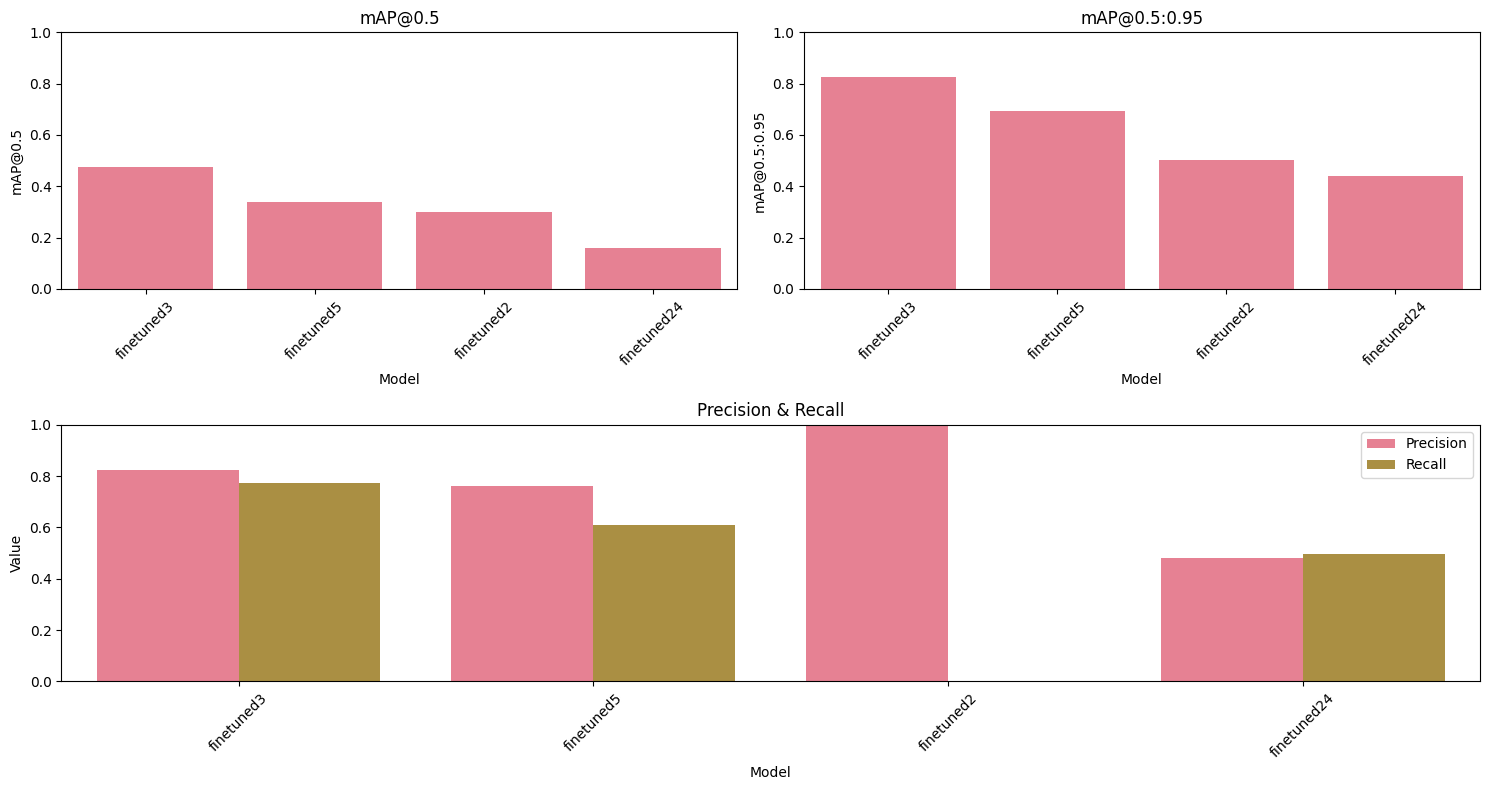

## 📈 Анализ обучения моделей

C:\Users\Egor\AppData\Local\Temp\ipykernel_15996\1119767595.py:208: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


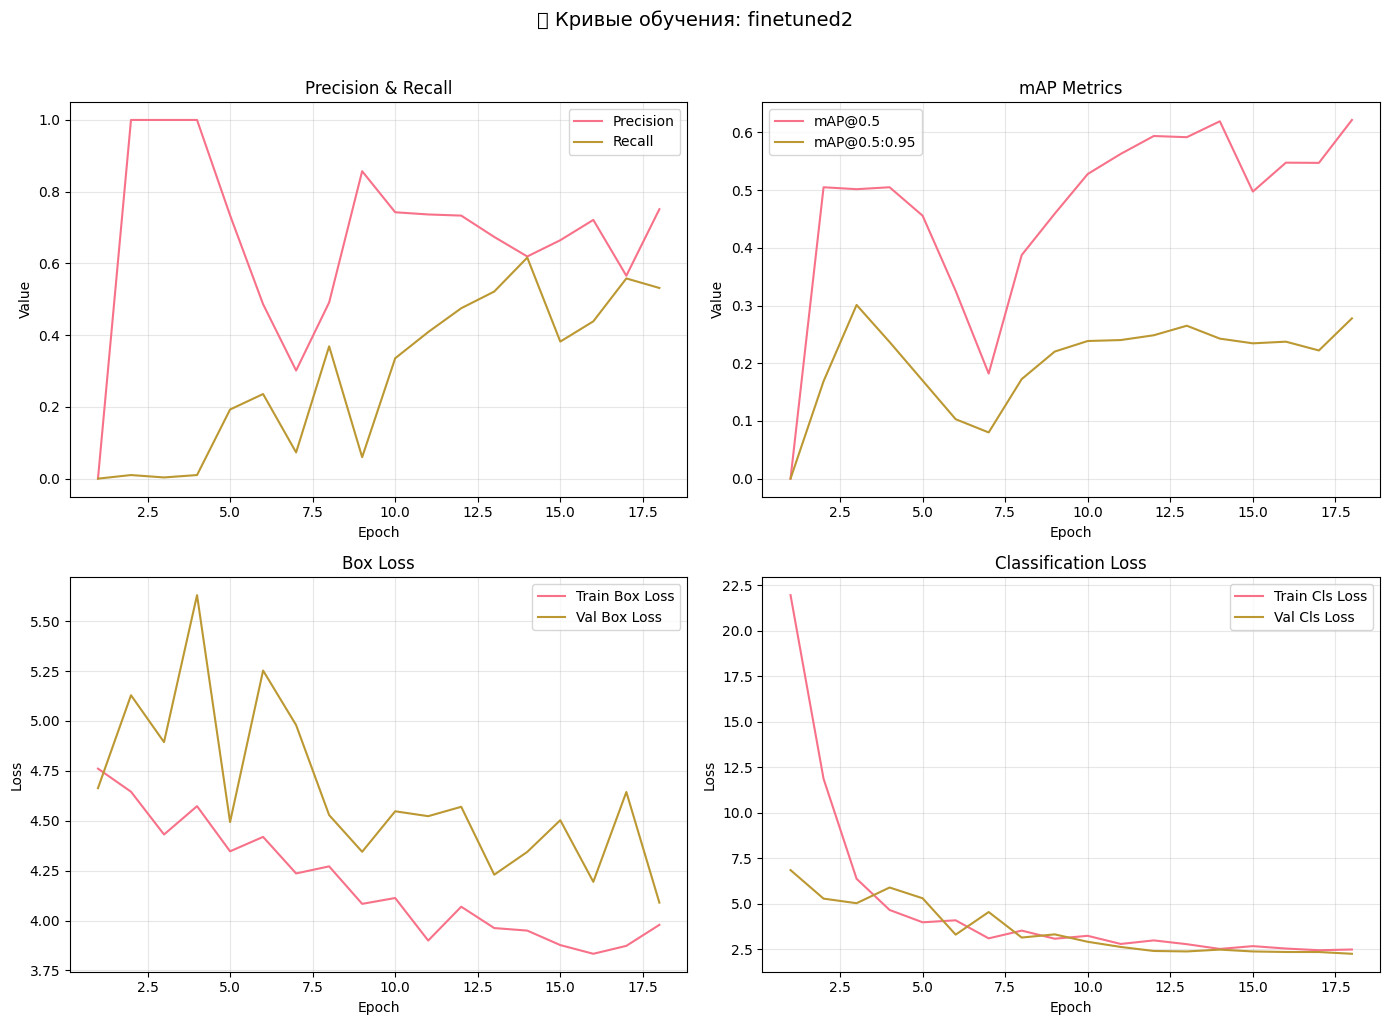

C:\Users\Egor\AppData\Local\Temp\ipykernel_15996\1119767595.py:208: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


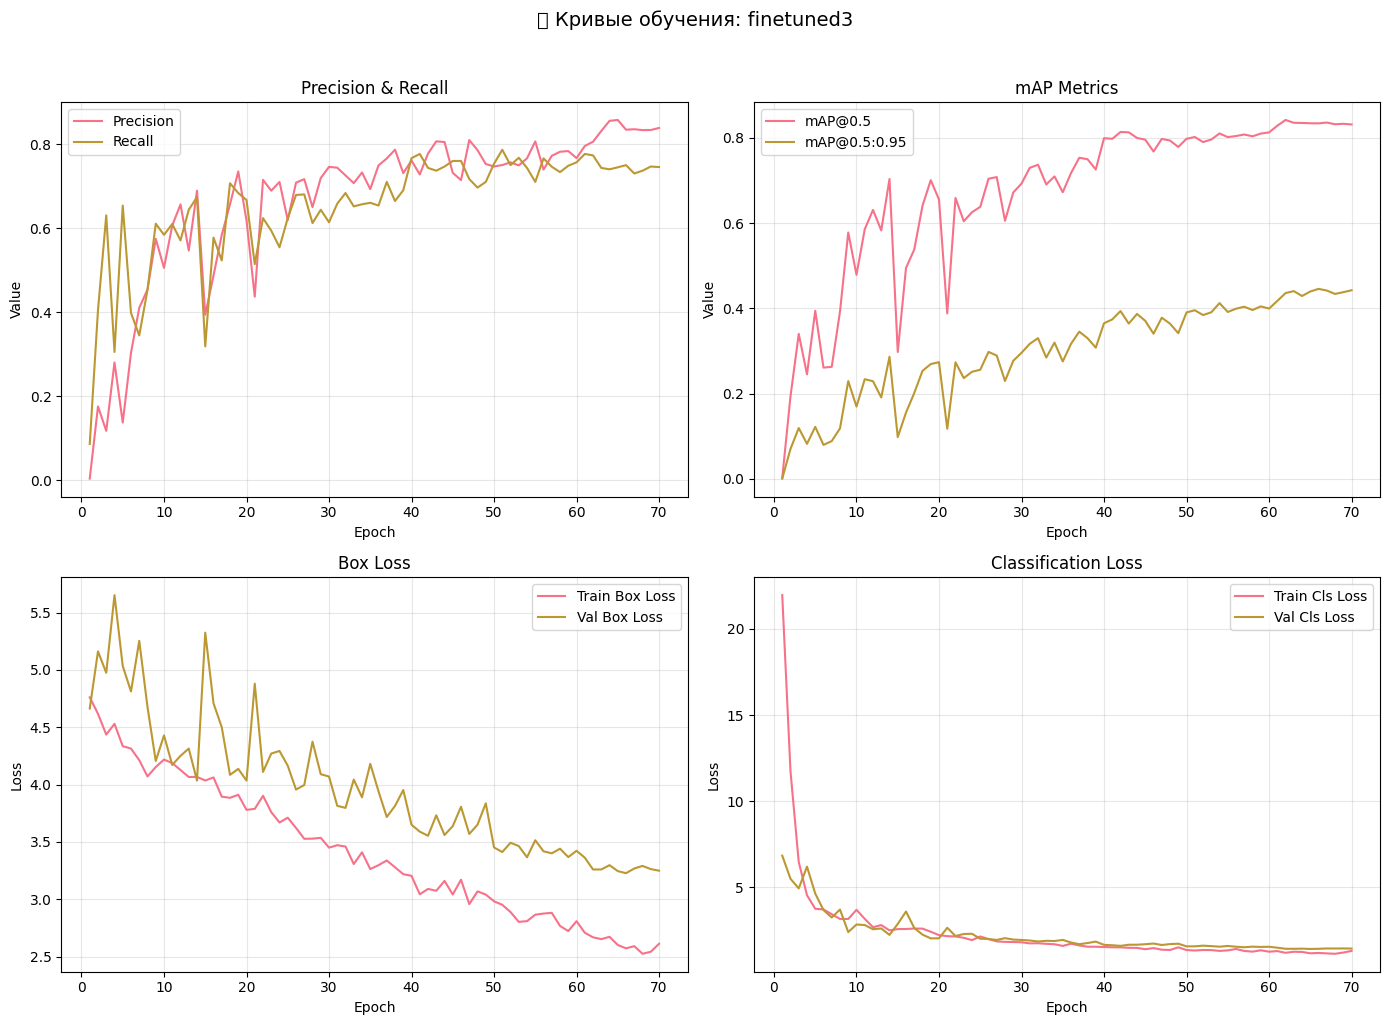

C:\Users\Egor\AppData\Local\Temp\ipykernel_15996\1119767595.py:208: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


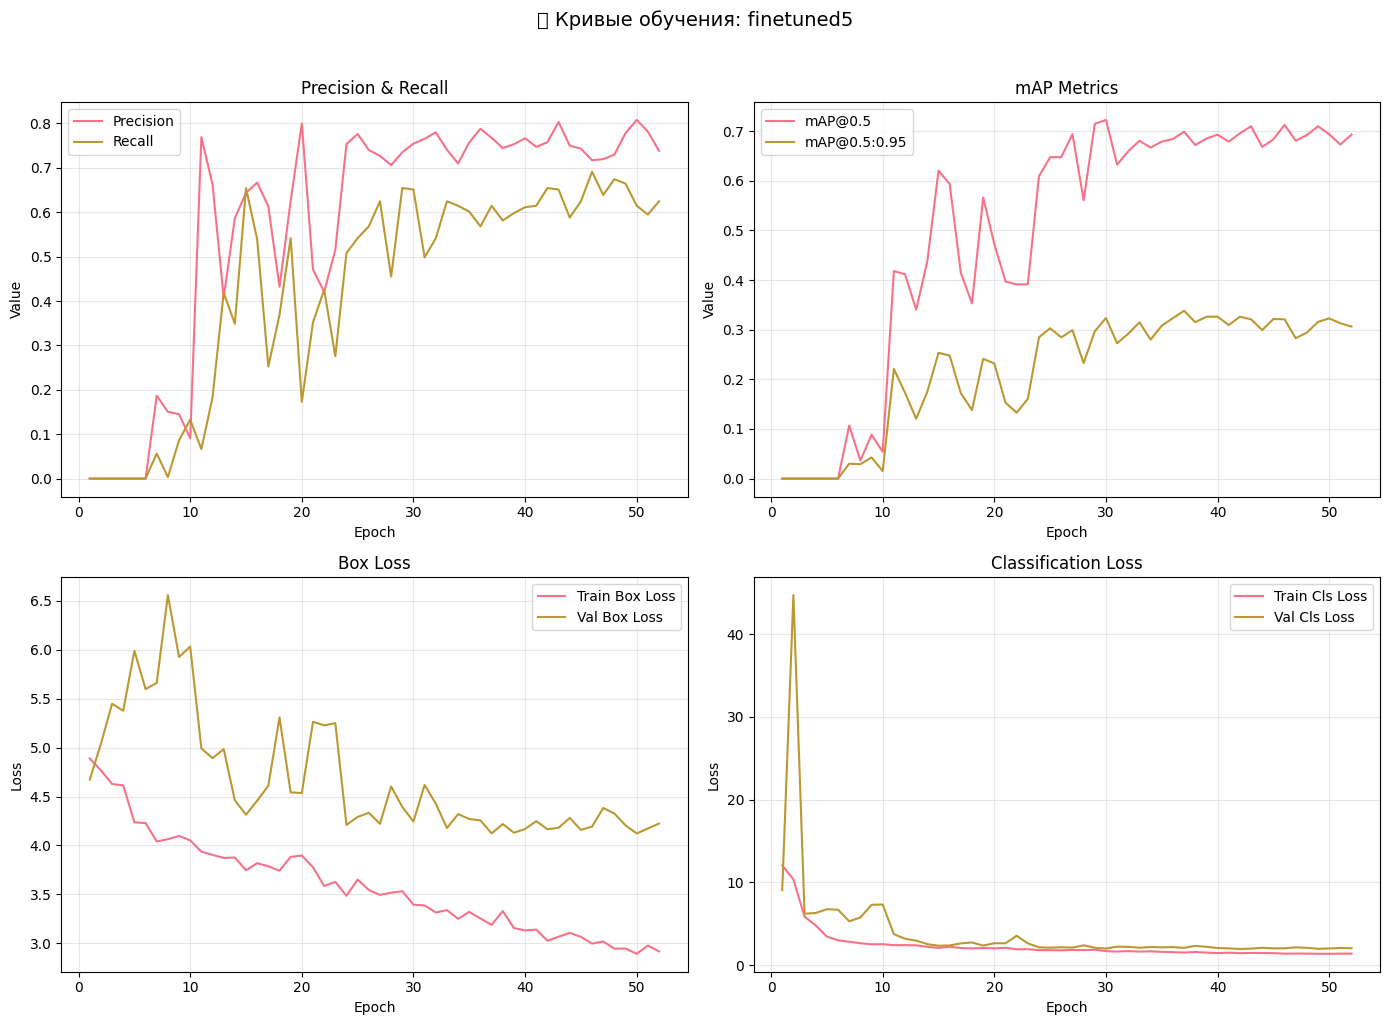

C:\Users\Egor\AppData\Local\Temp\ipykernel_15996\1119767595.py:208: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Egor\Desktop\ss\AI-Flow-Detecting\ai-core\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


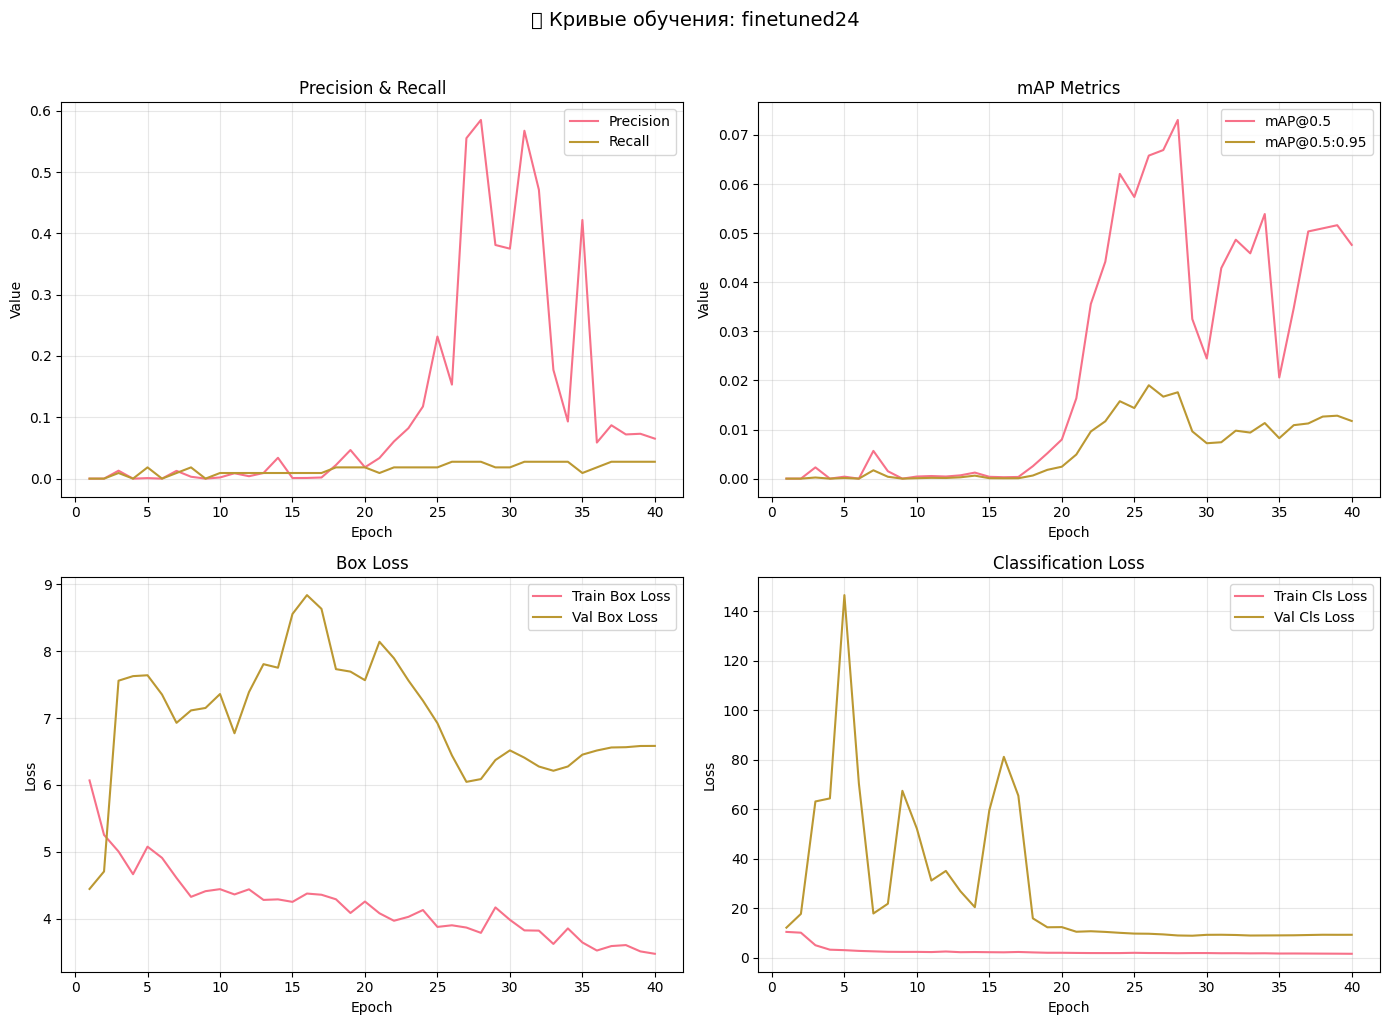

## 🖼️ Визуализация результатов

⚠️ Ошибка при загрузке изображений: [WinError 3] Системе не удается найти указанный путь: 'runs/train/yolov10n_bus_stop_finetunedfinetuned2'

⚠️ Ошибка при загрузке изображений: [WinError 3] Системе не удается найти указанный путь: 'runs/train/yolov10n_bus_stop_finetunedfinetuned3'

⚠️ Ошибка при загрузке изображений: [WinError 3] Системе не удается найти указанный путь: 'runs/train/yolov10n_bus_stop_finetunedfinetuned5'

⚠️ Ошибка при загрузке изображений: [WinError 3] Системе не удается найти указанный путь: 'runs/train/yolov10n_bus_stop_finetunedfinetuned24'

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [18]:
# %% [markdown]
# # 🏆 Сравнительный анализ моделей YOLOv10 для детекции остановок
# 
# **Автор:** [Ваше имя]  
# **Дата:** [Текущая дата]  
# 
# ## Цель исследования
# Сравнить производительность 6 дообученных моделей YOLOv10n на задаче детекции автобусных остановок и выбрать оптимальную модель.

# %%
# Импорт библиотек
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from IPython.display import display, Markdown
import seaborn as sns

# Настройка стилей
#plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline

# %% [markdown]
# ## 1. 📋 Конфигурация эксперимента

# %%
# Конфигурация моделей
MODELS = {
    "finetuned2": "runs/train/yolov10n_bus_stop_finetuned2/weights/best.pt", 
    "finetuned3": "runs/train/yolov10n_bus_stop_finetuned3/weights/best.pt",
    "finetuned5": "runs/train/yolov10n_bus_stop_finetuned5/weights/best.pt",
    "finetuned24": "runs/train/yolov10n_bus_stop_finetuned24/weights/best.pt"
}

TEST_IMAGE_PATH = "dataset/test/images"
DATA_YAML = "data.yaml"

# %% [markdown]
# ## 2. 🔍 Оценка моделей

# %%
def evaluate_model(model_path, model_name):
    """Полная оценка одной модели"""
    display(Markdown(f"### ⚙️ Модель: {model_name}"))
    
    try:
        # Загрузка модели
        model = YOLO(model_path)
        
        # Валидация
        display(Markdown("**Метрики на валидационном наборе:**"))
        metrics = model.val(
            data=DATA_YAML,
            split="val",
            batch=16,
            imgsz=640,
            conf=0.25,
            iou=0.6,
            device="0",
            name=f"val_{model_name.replace(' ', '_')}"
        )
        
        # Предсказание
        pred_dir = f"runs/train/yolov10n_bus_stop_finetuned{model_name.replace(' ', '_')}"
        _ = model.predict(
            source=TEST_IMAGE_PATH,
            imgsz=640,
            conf=0.25,
            save=True,
            save_txt=True,
            name=pred_dir,
            workers=0,
        )
        
        return {
            "name": model_name,
            "metrics": {
                "mAP50": metrics.box.map,
                "mAP50_95": metrics.box.map50,
                "precision": metrics.box.p,
                "recall": metrics.box.r
            },
            "pred_dir": pred_dir
        }
        
    except Exception as e:
        display(Markdown(f"❌ **Ошибка:** {str(e)}"))
        return None

# %%
# Запуск оценки всех моделей
results = []
for name, path in MODELS.items():
    if os.path.exists(path):
        res = evaluate_model(path, name)
        if res:
            results.append(res)
    else:
        display(Markdown(f"⚠️ **Модель {name} не найдена** по пути: `{path}`"))

# %% [markdown]
# ## 3. 📊 Сравнительный анализ метрик

# %%
# Создаем DataFrame с результатами
if results:
    df_metrics = pd.DataFrame([{
        "Model": r["name"],
        "mAP@0.5": r["metrics"]["mAP50"],
        "mAP@0.5:0.95": r["metrics"]["mAP50_95"],
        "Precision": r["metrics"]["precision"],
        "Recall": r["metrics"]["recall"]
    } for r in results])
    
    # Сортируем по mAP@0.5
    df_metrics = df_metrics.sort_values("mAP@0.5", ascending=False)
    
    display(Markdown("### 🏆 Таблица метрик"))
    display(df_metrics.style.background_gradient(cmap='YlGn', subset=["mAP@0.5", "mAP@0.5:0.95"]))
    
    # Визуализация
    plt.figure(figsize=(15, 8))
    
    # График mAP
    plt.subplot(2, 2, 1)
    sns.barplot(data=df_metrics, x="Model", y="mAP@0.5")
    plt.title("mAP@0.5")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # График mAP50-95
    plt.subplot(2, 2, 2)
    sns.barplot(data=df_metrics, x="Model", y="mAP@0.5:0.95")
    plt.title("mAP@0.5:0.95")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # График Precision-Recall
    plt.subplot(2, 1, 2)
    df_long = df_metrics.melt(id_vars="Model", value_vars=["Precision", "Recall"], 
                             var_name="Metric", value_name="Value")
    df_long["Value"] = df_long["Value"].astype(float)

    sns.barplot(data=df_long, x="Model", y="Value", hue="Metric")
    plt.title("Precision & Recall")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 4. 📈 Кривые обучения

# %%
def plot_training_curves(model_name):
    """Визуализация кривых обучения"""
    try:
        model_folder = model_name.replace(" ", "_")
        csv_path = f"runs/train/yolov10n_bus_stop_{model_folder}/results.csv"
        df = pd.read_csv(csv_path)
        
        plt.figure(figsize=(14, 10))
        plt.suptitle(f"📊 Кривые обучения: {model_name}", fontsize=14, y=1.02)
        
        # Метрики
        plt.subplot(2, 2, 1)
        plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
        plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.title("Precision & Recall")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 2)
        plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
        plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.title("mAP Metrics")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Потери
        plt.subplot(2, 2, 3)
        plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
        plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Box Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        plt.plot(df["epoch"], df["train/cls_loss"], label="Train Cls Loss")
        plt.plot(df["epoch"], df["val/cls_loss"], label="Val Cls Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Classification Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        display(Markdown(f"⚠️ **Ошибка при загрузке данных для {model_name}:** {str(e)}"))

# %%
# Отображаем кривые обучения для всех моделей
if results:
    display(Markdown("## 📈 Анализ обучения моделей"))
    for model in results:
        plot_training_curves(model["name"])

# %% [markdown]
# ## 5. 🖼️ Примеры предсказаний

# %%
def show_predictions(model_info, num_samples=3):
    """Отображение примеров предсказаний"""
    try:
        pred_dir = model_info["pred_dir"]
        images = [f for f in os.listdir(pred_dir) if f.endswith('.jpg')][:num_samples]
        
        if not images:
            display(Markdown(f"⚠️ Для модели {model_info['name']} не найдены примеры предсказаний"))
            return
            
        display(Markdown(f"### 🖼️ Примеры предсказаний: {model_info['name']}"))
        
        plt.figure(figsize=(15, 5))
        for i, img_name in enumerate(images, 1):
            img_path = os.path.join(pred_dir, img_name)
            img = Image.open(img_path)
            
            plt.subplot(1, num_samples, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Пример {i}")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        display(Markdown(f"⚠️ Ошибка при загрузке изображений: {str(e)}"))

# %%
# Показать примеры для всех моделей
if results:
    display(Markdown("## 🖼️ Визуализация результатов"))
    for model in results:
        show_predictions(model)

# %% [markdown]
# ## 6. 🏆 Выводы и рекомендации

# %%
if results:
    best_model = max(results, key=lambda x: x["metrics"]["mAP50"])
    
    display(Markdown(f"""
    ## 🎯 Итоговые результаты
    
    **Лучшая модель:** `{best_model['name']}`  
    **mAP@0.5:** `{best_model['metrics']['mAP50']:.3f}`  
    **mAP@0.5:0.95:** `{best_model['metrics']['mAP50_95']:.3f}`  
    **Precision:** `{best_model['metrics']['precision']:.3f}`  
    **Recall:** `{best_model['metrics']['recall']:.3f}`
    
    ### Рекомендации:
    1. Использовать модель `{best_model['name']}` для продакшена
    2. Для улучшения результатов:
       - Увеличить разнообразие данных обучения
       - Попробовать другие архитектуры (YOLOv10s/m/l)
       - Настроить гиперпараметры обучения
    """))
else:
    display(Markdown("## ❌ Не удалось получить результаты"))